Configure the plotting machinery

In [1]:
%pylab inline
%config InlineBackend.figure_format = 'svg'
import json
s = json.load( open("mplrc.json") )
matplotlib.rcParams.update(s)
matplotlib.rcParams['figure.figsize'] = 9,4
black="#404060" # plots containing "real black" elements look artificial

Populating the interactive namespace from numpy and matplotlib


/home/boffi/lib/miniconda3/lib/python3.6/site-packages/matplotlib/__init__.py:800: MatplotlibDeprecationWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  mplDeprecation)


Configure the rendering of this notebook with CSS

In [2]:
from IPython.core.display import HTML
def css_styling():
    styles = open("custom.css", "r").read()
    return HTML(styles)
# css_styling()

## Response Analysis in the Frequency Domain<br> <small>an Example</small>

##### Samples

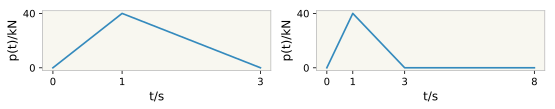

In [3]:
figsize(9.0,1.1);
subplot(1,2,1);plot((0,1,3),(0,40,0));xticks((0,1,3)); yticks((0,40))
xlabel('t/s');ylabel('p(t)/kN');grid();
subplot(1,2,2);plot((0,1,3,8),(0,40,0,0));xticks((0,1,3,8)); yticks((0,40))
xlabel('t/s');ylabel('p(t)/kN');grid();


We want to replicate the solution obtained for a triangular load using the _Duhamel Integral_.

Our load is 3s long, but we need a stretch of zeros to damp out the response and _simulate_ rest initial conditions. We add zeros to the end of the load up to 
a total duration of 8s. The period of our loading is hence, rather arbitrarily,
$T=8\,{}$s.

In our exercise, we are free to choose the number of _samples per second_,
so we chose 512 sps.

How many samples are there? $N = 8\times512=4096$, note that $N$ is a power of 2.

In [4]:
T = 8
sps = 512
print("The Nyquist frequency is ", sps/2.0,"Hz")

The Nyquist frequency is  256.0 Hz


##### Load definition

The _array_ `t` contains the times at which our signal was sampled, the load `p` is computed using the library function `where`, syntactically  very similar to `IF` in a spreadsheet

In [5]:
t = arange(0,T,1./sps)
p = where(t>3, 0, where(t<1, t*40000, 40000*(3-t)/2))

Am I sure that the _list_ p contains the values of the loading?

Let's try to plot p vs t...

(-5000, 45000)

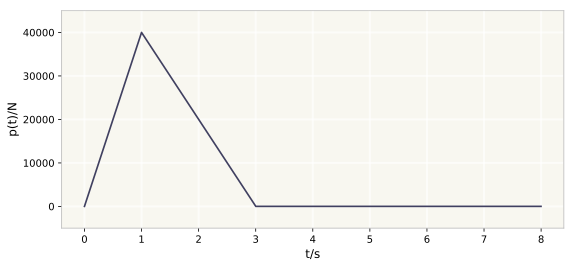

In [6]:
matplotlib.rcParams['figure.figsize'] = 9,4
plot(t, p, black) ; xlabel("t/s") ; ylabel("p(t)/N")
ylim((-5000,45000))

It looks OK...

##### FFT of the loading

Now, the fast Fourier transform of the sequence p is computed, and given a name, P.

It is customary to denote Fourier pairs by the same letter, the small letter for the time domain representation and the capital letter for the frequency domain representation.

In [7]:
P = fft.fft(p)
iP = fft.ifft(P)

I have computed also the _inverse_ FFT of the FFT of the loading, naming it iP, it is a sequence of complex numbers and here we plot the real and the imaginary part of each component versus time.

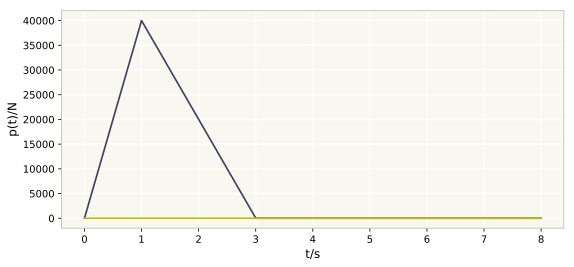

In [8]:
plot(t,real(iP),black,t,1*imag(iP),'y') ; xlabel("t/s") ; ylabel("p(t)/N") ;

It seems OK...

Next, we use a convenience function to compute a sequence of frequencies (in Hertz!) associated with the components of P, the FFT of p. The parameters are the number of points and the sampling interval..

Note that the sequence of frequencies has a discontinuity when the Nyquist frequency
is reached, i.e., the next frequency is the most negative one.

In [9]:
f = fft.fftfreq(T*sps, 1./sps)
f, f[2046:2051]

(array([ 0.   ,  0.125,  0.25 , ..., -0.375, -0.25 , -0.125]),
 array([ 255.75 ,  255.875, -256.   , -255.875, -255.75 ]))

##### Plots of P, the FFT of p

The x axis is streching over the interval $-f_\text{Ny}$, $+f_\text{Ny}$

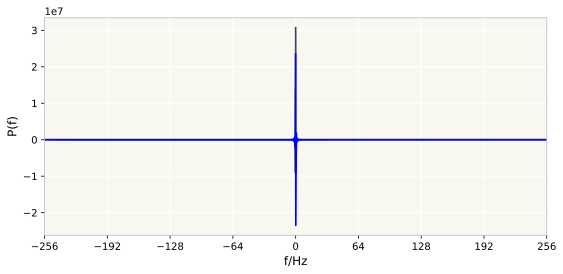

In [10]:
plot(f,real(P), black, f,imag(P),'b')
xlim(-256,256) ; xticks(range(-256,257,64))
xlabel("f/Hz") ; ylabel("P(f)") ;

The plot above is not much clear, because the frequency components are significantly different from zero only in a narrow range of frequencies around the origin.

In the next 3 plots we zoom near the origin of the frequency axis to have a bit more of detail. There are 3 plots, first the absolute value of P vs f, then the real part and finally the imaginary part of P, versus f.

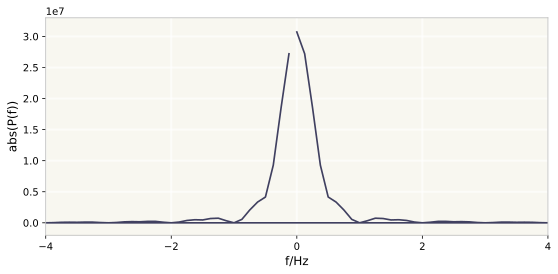

In [11]:
plot(f,abs(P), black)
xticks(range(-4,5,2))
xlabel("f/Hz") ; ylabel("abs(P(f))")
xlim(-4,4) ; ylim(-0.2E7,3.3E7);

Not afwully nice, this last plot...the baseline and the missing line
at the left of the zero are artifacts, due do the particular sequence
with which the positive and negative frequencies are arranged in the DFT output.

To obviate these problems we can use the function `fftshift`, that reorders (shifts)
the elements in an array such that the sequence goes from the most negative
frequency to the most positive.

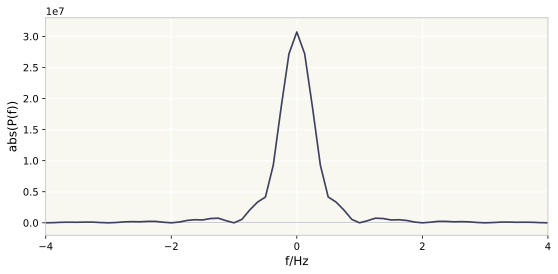

In [12]:
plot(fftshift(f),fftshift(abs(P)), black)
axhline(0,color=black, linewidth=0.25)
xticks(range(-4,5,2))
xlabel("f/Hz") ; ylabel("abs(P(f))")
xlim(-4,4) ; ylim(-0.2E7,3.3E7);

and now the other two plots I promised,

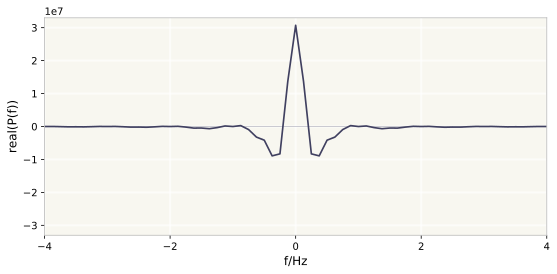

In [13]:
plot(fftshift(f),fftshift(real(P)), black)
axhline(0,color=black, linewidth=0.25)
xticks(range(-4,5,2))
xlabel("f/Hz") ; ylabel("real(P(f))")
xlim(-4,4) ; ylim(-3.3E7,3.3E7);

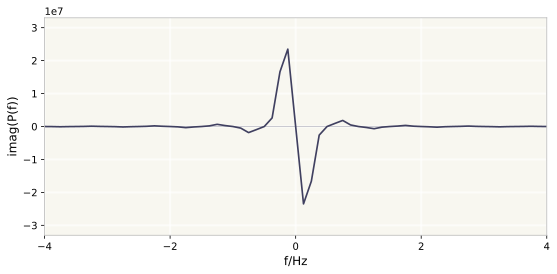

In [14]:
plot(fftshift(f),fftshift(imag(P)), black)
axhline(0,color=black, linewidth=0.25)
xticks(range(-4,5,2))
xlabel("f/Hz") ; ylabel("imag(P(f))")
xlim(-4,4) ; ylim(-3.3E7,3.3E7);

##### The response function

Until now, we did without the SDOF, now it's time to describe it and derive its _response function_.

All the parameters are the same as in the excel example, we compute k because we need it to normalize the response.

In [15]:
z = 0.1; fn = 1/0.6 ; m =6E5 ; wn = fn*2*pi ; k = m*wn**2
def H(f):
    b = f/fn
    return 1./((1-b*b)+1j*(2*z*b))

As usual, we plot the response function, or rather the absolute value of, against a short span of the frequency axis, centered about the origin, to show the details of the response function itself.

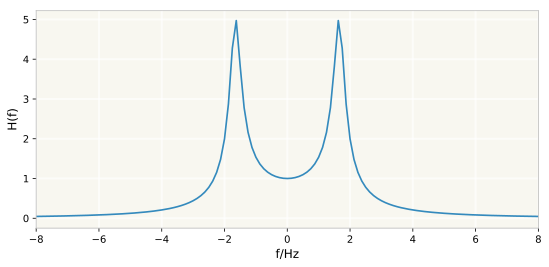

In [16]:
plot(fftshift(f),fftshift(abs(H(f)))) ; xlabel("f/Hz") ; xlim(-8,8) ; ylabel("H(f)") ;

##### Computing the response

The FFT of the response is computed multiplying, term by term, P by the response or _transfer_ function, then we compute the IFFT of X to obtain x, the _time domain representation_ of the response domain.

In [17]:
X = [ P_*H(f_) for P_, f_ in zip(P,f)]
x = ifft(X)/k

Note that the response function is _periodic_ with period $T=8\,{}$s.

In the end, we remain with the task of plotting the response function, that is the real part of `x`. Just to be certain we plot also the imaginary part of `x`, so we can be sure that it is negligible with respect to the real part

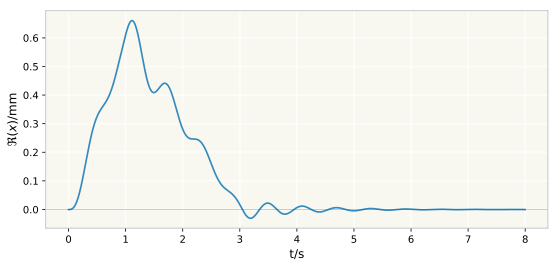

In [18]:
plot(t,1000*real(x))
xlabel("t/s"); ylabel(r"$\Re(x)/$mm");
axhline(0,color=black, linewidth=0.25)
show()



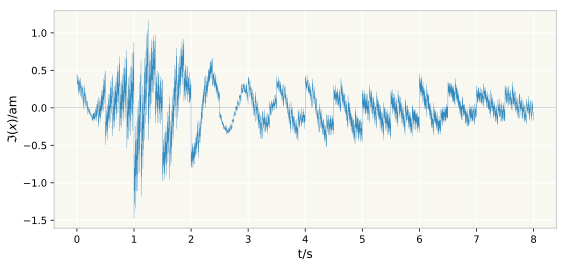

In [19]:
plot(t,1E18*imag(x),linewidth=0.33)
axhline(0,color=black, linewidth=0.25)
xlabel("t/s"); ylabel(r"$\Im(x)/$am");
show()


##### The zero trail

The importance of the zero trail to _adjust_ for initial rest condition cannot be
underestimated. The length required depends, of course, on how much damped our system is,
the lesser the damping, the longer the time required to damp out the response.

Lets try to see what happens if we go from $\zeta=0.10$ to $\zeta=0.01$:

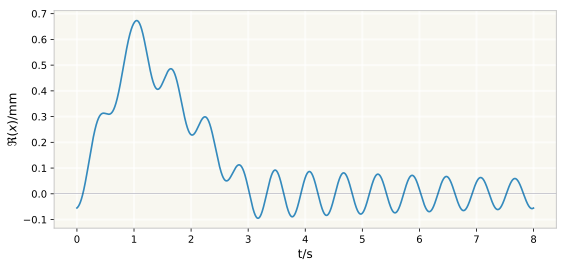

In [20]:
z = 0.01
X = [ P_*H(f_) for P_, f_ in zip(P,f)]
x = ifft(X)/k
plot(t,1000*real(x))
xlabel("t/s"); ylabel(r"$\Re(x)/$mm");
axhline(0,color=black, linewidth=0.25)
show()

